In [1]:
! pip install torchvision

In [2]:
#importing required libraries

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.animation as animation
import random
from IPython.display import HTML 

from torch.autograd import Variable
from torchvision.utils import save_image
import os 
import cv2
import torch.backends.cudnn as cudnn

from matplotlib.pyplot import *
from pylab import *
import torchvision.utils as vutils

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize ((0.485,0.456,0.406),(0.229,0.224,0.225))
   ])

train_set=torchvision.datasets.CIFAR10(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transform
)


test_set=torchvision.datasets.CIFAR10(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transform
)




Files already downloaded and verified
Files already downloaded and verified


In [7]:
batch_size = 64
valid_size = 0.2

In [8]:
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



for i in range(len(train_set)):
    print('size of image {} label {}'.format(train_set[i][0].size(), train_set[i][1]))
    if i>2:
        break

size of image torch.Size([3, 32, 32]) label 6
size of image torch.Size([3, 32, 32]) label 9
size of image torch.Size([3, 32, 32]) label 9
size of image torch.Size([3, 32, 32]) label 4


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle = False,
    sampler = train_sampler, num_workers = 0,
    collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None
)   






test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle = True 
   
)   




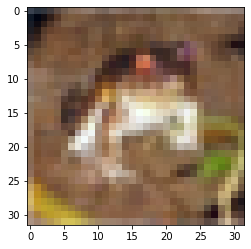

tensor([2, 0, 3, 2, 7, 2, 2, 8, 4, 6, 0, 6, 3, 7, 1, 3, 8, 0, 5, 6, 4, 6, 6, 9,
        4, 4, 7, 2, 7, 2, 4, 5, 5, 2, 5, 9, 5, 5, 2, 0, 4, 7, 2, 2, 4, 3, 3, 9,
        6, 3, 8, 1, 4, 2, 7, 5, 4, 9, 3, 5, 2, 7, 6, 2])
torch.Size([64, 3, 32, 32])


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

torchimage = train_set[0][0]
npimage=torchimage.permute(1,2,0)
npimage -= npimage.min()
npimage /= npimage.max()

plt.imshow(npimage)
plt.show()


#----------------------#

dataiter = iter(train_loader)
images,labels = dataiter.next()
print(labels[0:])
print(images.size())

classes = ['airplane','automobile','bird','cat','deer','dog',
          'frog','horse','ship','truck']

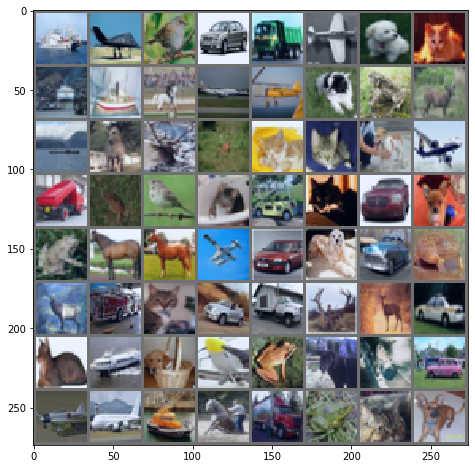

 ship airplane  bird automobile truck airplane   dog   cat


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img -= img.min()
    img /= img.max()
    
    npimg = img.numpy()
    plt.figure(figsize = (8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [12]:
#initialisation

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1: 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)        #30*30*32
        self.conv2 = nn.Conv2d(32, 64, 3)       #28*28*64
        self.pool = nn.MaxPool2d(2, 2)          #14*14*64
        self.conv3 = nn.Conv2d(64, 128, 3)       #12*12*128
        self.pool = nn.MaxPool2d(2, 2)          #6*6*128
        self.conv4 = nn.Conv2d(128, 254, 3)       #4*4*254
        self.conv5 = nn.Conv2d(254, 508, 1)       #4*4*508
        self.fc1 = nn.Linear(508 * 4 * 4, 10)
    
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
       
        x = x.view(-1, 508 * 4 * 4)
        x = self.fc1(x)
        
        return  F.log_softmax(x, dim = 1)
       
net = Net()

In [18]:
for name, param in net.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([32, 3, 3, 3])
conv1.bias 		 torch.Size([32])
conv2.weight 		 torch.Size([64, 32, 3, 3])
conv2.bias 		 torch.Size([64])
conv3.weight 		 torch.Size([128, 64, 3, 3])
conv3.bias 		 torch.Size([128])
conv4.weight 		 torch.Size([254, 128, 3, 3])
conv4.bias 		 torch.Size([254])
conv5.weight 		 torch.Size([508, 254, 1, 1])
conv5.bias 		 torch.Size([508])
fc1.weight 		 torch.Size([10, 8128])
fc1.bias 		 torch.Size([10])


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.115
[1,   200] loss: 0.114
[1,   300] loss: 0.112
[1,   400] loss: 0.108
[1,   500] loss: 0.104
[1,   600] loss: 0.101
[2,   100] loss: 0.096
[2,   200] loss: 0.094
[2,   300] loss: 0.091
[2,   400] loss: 0.089
[2,   500] loss: 0.086
[2,   600] loss: 0.085
[3,   100] loss: 0.082
[3,   200] loss: 0.082
[3,   300] loss: 0.080
[3,   400] loss: 0.079
[3,   500] loss: 0.077
[3,   600] loss: 0.076
[4,   100] loss: 0.075
[4,   200] loss: 0.074
[4,   300] loss: 0.074
[4,   400] loss: 0.074
[4,   500] loss: 0.072
[4,   600] loss: 0.071
[5,   100] loss: 0.071
[5,   200] loss: 0.069
[5,   300] loss: 0.069
[5,   400] loss: 0.069
[5,   500] loss: 0.068
[5,   600] loss: 0.067
[6,   100] loss: 0.067
[6,   200] loss: 0.066
[6,   300] loss: 0.065
[6,   400] loss: 0.065
[6,   500] loss: 0.065
[6,   600] loss: 0.063
[7,   100] loss: 0.062
[7,   200] loss: 0.061
[7,   300] loss: 0.062
[7,   400] loss: 0.060
[7,   500] loss: 0.060
[7,   600] loss: 0.061
[8,   100] loss: 0.059
[8,   200] 

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

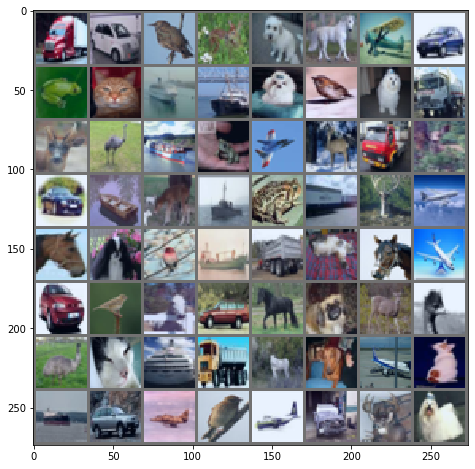

GroundTruth:  truck automobile  bird  deer   dog horse airplane automobile


In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images /= images.max()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird  deer  frog  deer


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 75 %
Accuracy of automobile : 87 %
Accuracy of  bird : 60 %
Accuracy of   cat : 38 %
Accuracy of  deer : 72 %
Accuracy of   dog : 50 %
Accuracy of  frog : 93 %
Accuracy of horse : 75 %
Accuracy of  ship : 77 %
Accuracy of truck : 78 %
